# Personalised Mecidine - Exploratory Data Analysis

## Goal of project
Automatically classify genetic mutations that contribute to cancer tumor growth drivers) vs. presence of mutations that don’t affect the tumors (passengers)

## Importing data

In [143]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup
import re
%matplotlib inline

In [144]:
var_path = "Data/training_variants"
text_path = "Data/training_text"

d_train = pd.read_csv(var_path)
d_text = pd.read_csv(text_path, sep = "\|\|", skiprows=1, names = ['ID','Text'], engine="python")

## Variants file

### Variable Understanding

In [145]:
d_train.dtypes

ID            int64
Gene         object
Variation    object
Class         int64
dtype: object

- ID - A specific gene of the specimen
- Gene - The specific gene where the mutation took place
- Variation - the nature of the mutation
- Class - Class which we must predict
    - between 1 and 9

In [146]:
d_train.apply(pd.Series.nunique)

ID           3321
Gene          264
Variation    2996
Class           9
dtype: int64

We now know that there are 3321 records in our training set - all of which are unique.
Although we have 264 unique genes and 2996 unique variations.
Lastly there are 9 classes.

In [147]:
d_train.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

We know that there are no null values in the dataset.

### Univariant Analysis

### Class

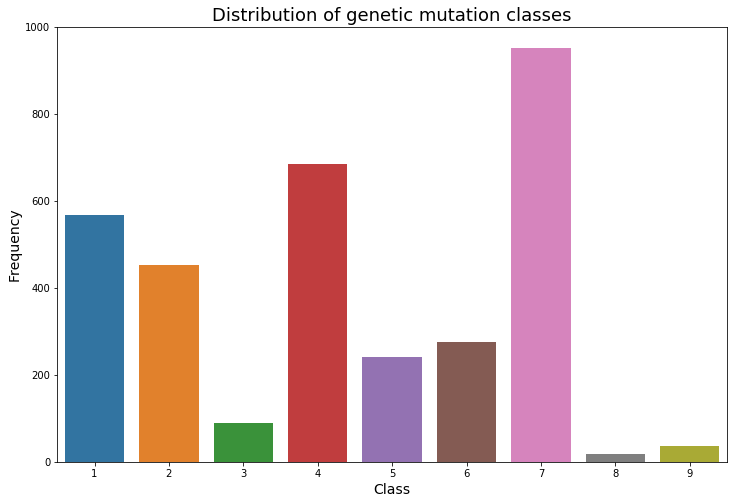

In [148]:
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=d_train)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Distribution of genetic mutation classes", fontsize=18)
plt.show()

- Class 7 is very common, followed by 1, 2, and 4
- Class 3, 8, 9 are not very common

### Gene

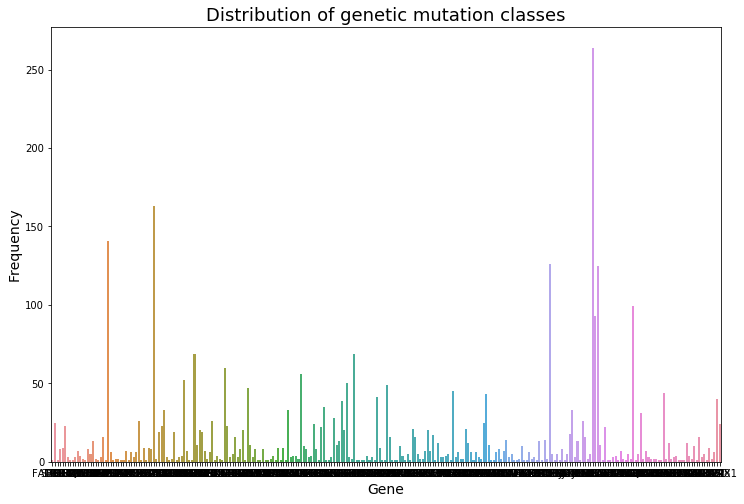

In [149]:
plt.figure(figsize=(12,8))
sns.countplot(x="Gene", data=d_train)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Gene', fontsize=14)
plt.title("Distribution of genetic mutation classes", fontsize=18)
plt.show()

In [150]:
# Find top 10 genes
gene_freq = d_train['Gene'].value_counts()
print("Top-10 Gene Occurances\n")
print(gene_freq.head(10))

Top-10 Gene Occurances

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
Name: Gene, dtype: int64


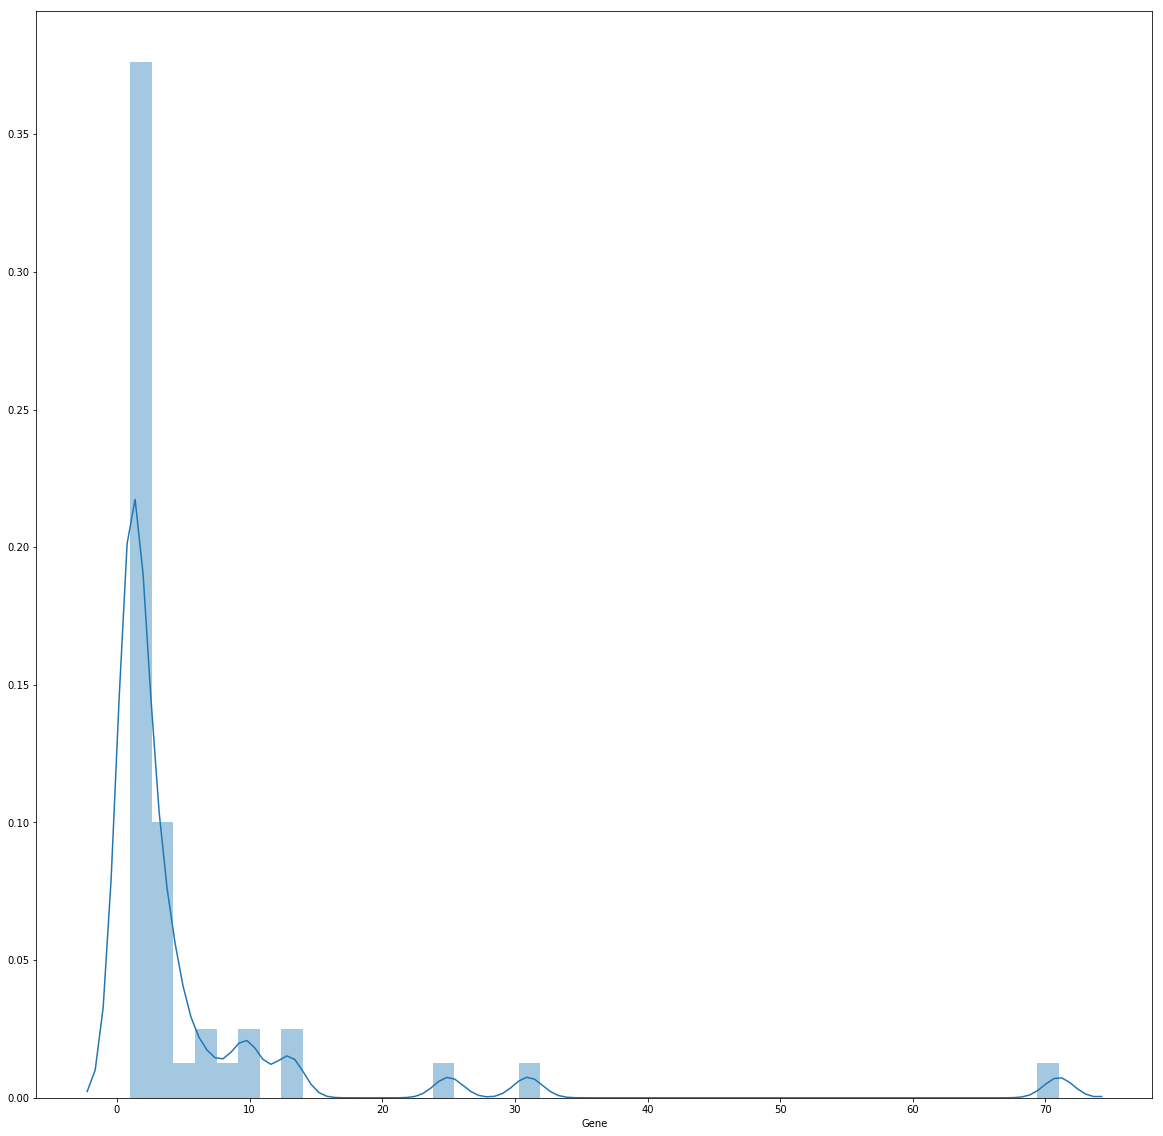

In [151]:
#Look at distribution of frequency of genes
plt.figure(figsize=(20,20))
sns.distplot(gene_freq.value_counts())

- There are a lot of genes that appear only once, and quite a few appear twice

In [152]:
#Get frequency and standard deviation for genes occuring more than once
filter_genes = gene_freq[gene_freq > 2]
print(stats.kurtosis(filter_genes),stats.skew(filter_genes))

24.253454297558463 4.360256036389982


### Variation

In [153]:
print("Description of Variation")
print(d_train['Variation'].describe())
print("\nTop Five Variations")
print(d_train['Variation'].value_counts().head(5))

Description of Variation
count                     3321
unique                    2996
top       Truncating Mutations
freq                        93
Name: Variation, dtype: object

Top Five Variations
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
Name: Variation, dtype: int64


- There are a lot of unique variation
- Only the top foud variations appear somewhat often
- Variation may not provide much information

## Bivariant Analysis

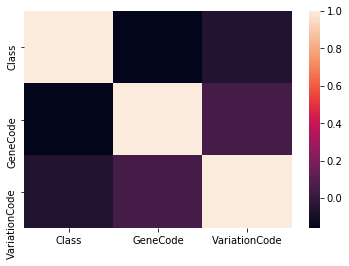

In [154]:
# Converting Gene and Variation to categories
d_train['Gene'] = d_train['Gene'].astype('category')
d_train['Variation'] = d_train['Variation'].astype('category')
d_train['Gene'].head().cat.codes
d_train['GeneCode'] = d_train['Gene'].cat.codes
d_train['VariationCode'] = d_train['Variation'].cat.codes
d_train.head()

# Calculate correlations
corr = d_train[['Class', 'GeneCode', 'VariationCode']].corr()

# Heatmap
sns.heatmap(corr)
plt.figure(figsize=(10,10))
plt.show()

- There does not appear to be much correlation anywhere

### Gene and Variation

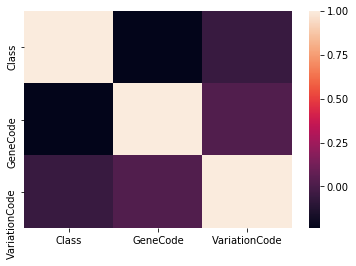

In [155]:
#Correlation using top 20 genes
top_20_genes = d_train[(d_train['Gene'].isin(gene_freq.head(20).index))]

# Calculate correlations
corr = top_20_genes[['Class', 'GeneCode', 'VariationCode']].corr()

# Heatmap
sns.heatmap(corr)
plt.show()

- Slightly better, but still does not appear to have much correlation

### Top 20 Gene Distribution by Class

In [156]:
#top_20_genes.head()
#g = sns.factorplot("Gene", hue="Gene", col="Class", data=top_20_genes, kind="count")

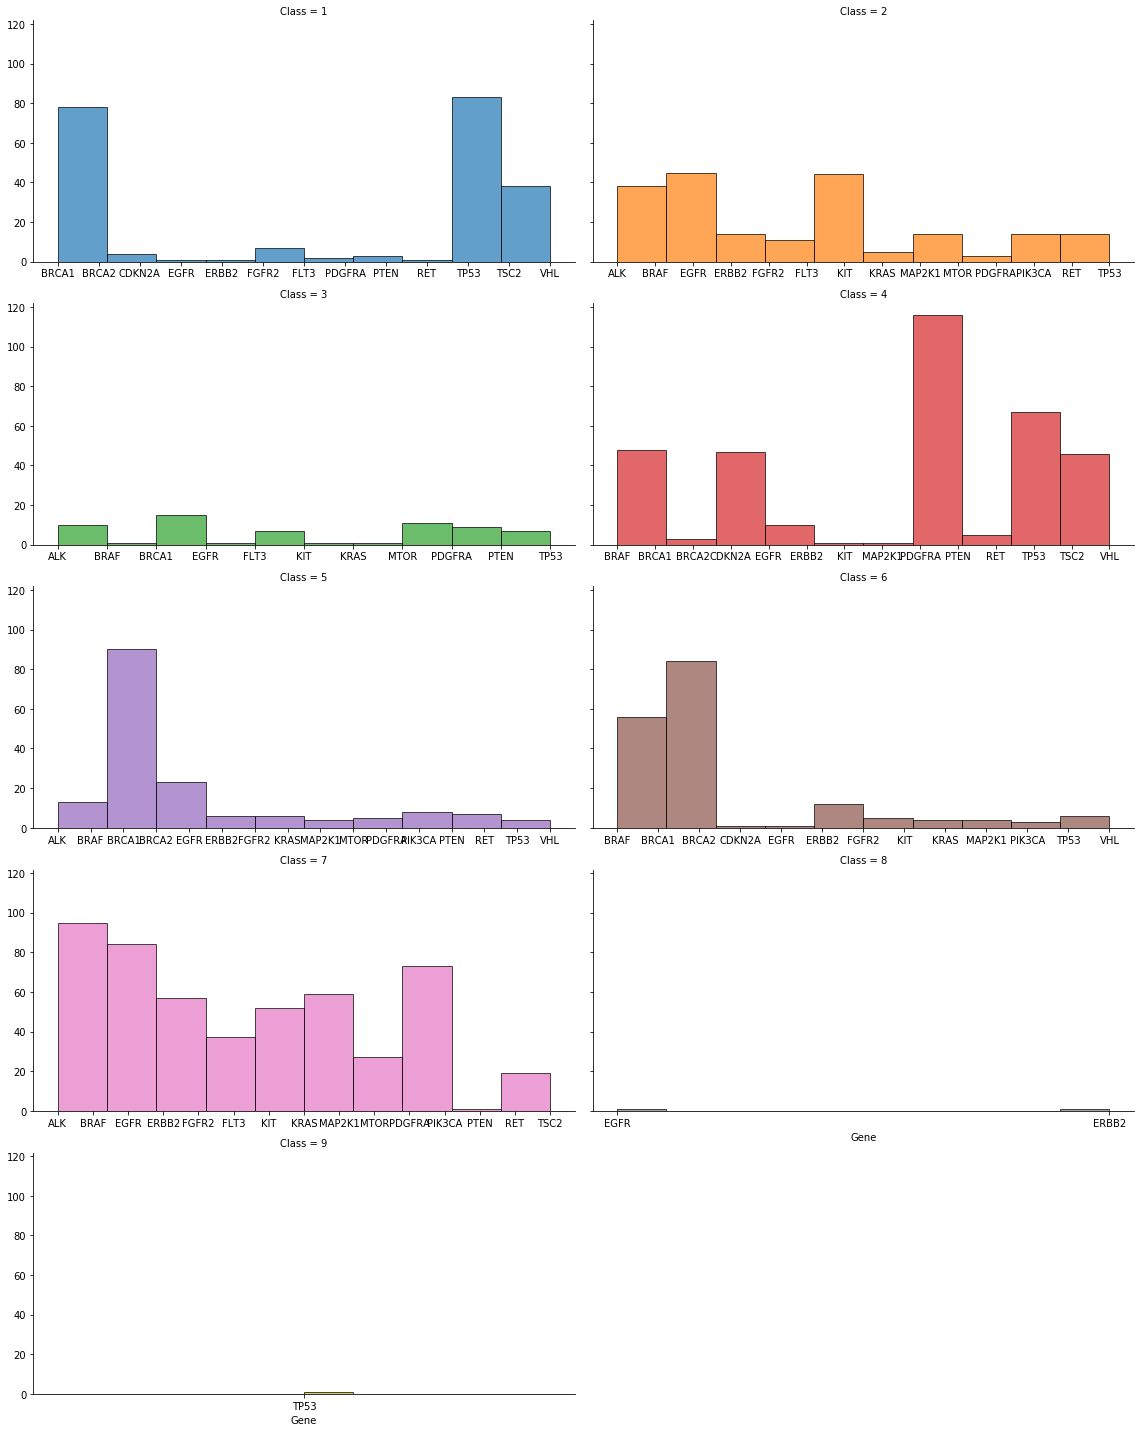

In [157]:
g = sns.FacetGrid(top_20_genes, col="Class", col_wrap=2, size=4, aspect=2, hue="Class", margin_titles=True, sharex=False)
g.map(plt.hist, "Gene", alpha=0.7, edgecolor='#000000');
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
plt.tight_layout()

## Text File (Natural Language Processing)

### Categorize by Class

In [158]:
merged_data = pd.merge(d_train,d_text,on='ID')
merged_data['Class'].value_counts()


7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

In [160]:
#Get class1 text
class1_text = merged_data[merged_data['Class'] == 1]['Text']
class1_text = pd.DataFrame(class1_text)
class1_text = class1_text.reset_index(drop=True)
#class1_text

In [162]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))  
clean_review = review_to_words( class1_text["Text"][0] )
#print(clean_review)

In [163]:
# Get the number of reviews based on the dataframe column size
num_reviews = class1_text["Text"].size

print("Cleaning and parsing the training set movie reviews...\n")
clean_train_reviews = []
for i in range( 0, num_reviews ):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
        print("Review %d of %d\n" % ( i+1, num_reviews ))                                                               
    clean_train_reviews.append( review_to_words( class1_text["Text"][i] ))

Cleaning and parsing the training set movie reviews...



In [164]:
print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

Creating the bag of words...



In [165]:
print(train_data_features.shape)

(568, 5000)


In [166]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
#print(vocab)

In [168]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)
#print(train_data_features)
#print(type(vocab))
# For each, print the vocabulary word and the number of times it 
# appears in the training set
#for tag, count in zip(vocab, dist):
#    print(count, tag)

In [169]:
df1 = pd.DataFrame(vocab, columns=['word'])
df2 = pd.DataFrame(dist, columns=['count'])
df.head(10)
df2.head(10)
df3 = pd.concat([df1, df2], axis=1)
df3.head(10)
df3.set_index('word')
df3 = df3.sort_values('count', ascending=False)
df3.head()
df4 = df3.set_index('word')['count']
#print(df4)
d = df4.to_dict()
#print(d)

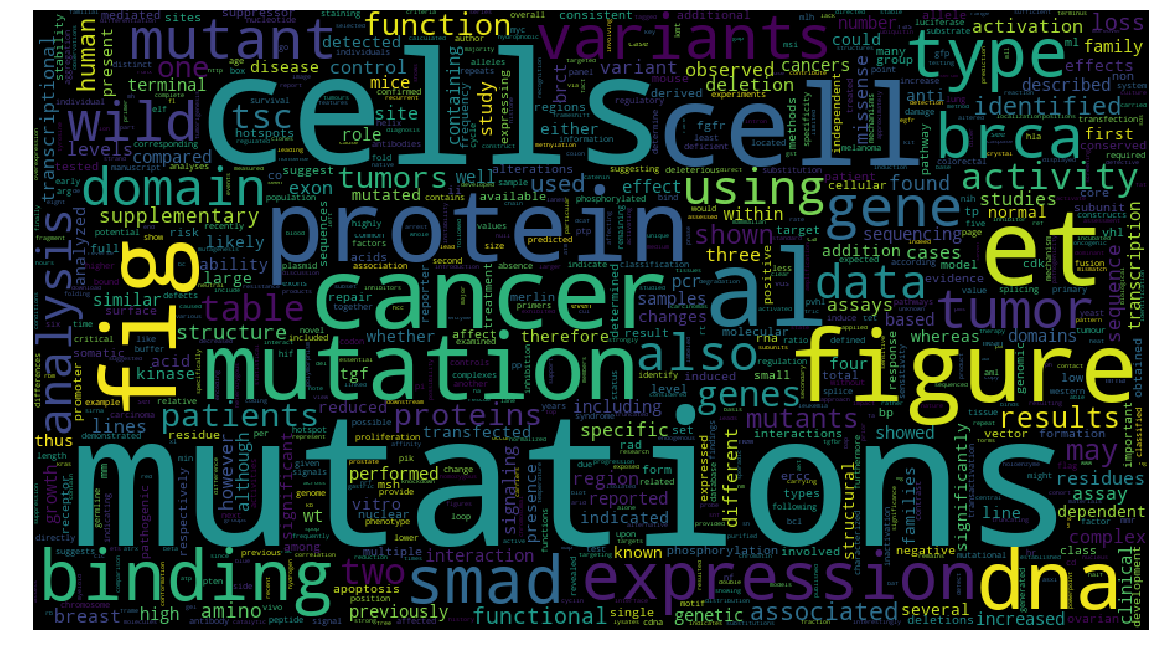

In [170]:
from wordcloud import WordCloud
cloud = WordCloud(background_color="white")

positive_cloud = WordCloud(width=900,height=500, max_words=1628,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(d)
plt.figure(figsize=(20,20))
plt.imshow(positive_cloud)
plt.axis("off")
plt.show()

## Challenges

- Learning to deal with common challenges of text mining
- Using Natural Language processing libraries/toolkits in a Biomedical environment
    - Proposed solution: Biomedical terminology banks are available for the purposes of text mining although operating system restrictions and pay walls must be overcome. 
- Some test data is machine generated therefore text analysis may give unusual results
    - Proposed solution: Parse through machine generated text and differentiate between noise and actual data.

## Timeline

- Data Exploration: January 22, 2018 - February 5, 2018 (Weeks 3-5)
- Data Preparation: February 5, 2018 - March 2, 2018 (Weeks 5-8)
- Modeling: March 2, 2018 - March 20, 2018 (Weeks 8-10)
- Documentation and Poster: March 20, 2018 - April 6, 2018 (Weeks 10-12)